In [58]:
%pip install pandas numpy==1.21.4 numba==0.53.0 torch pytorch-lightning shap ipywidgets matplotlib > /dev/null

Note: you may need to restart the kernel to use updated packages.


In [69]:
import torch
from torch import nn
from torch.utils import data

import pandas as pd

import numpy as np

import pytorch_lightning as pl

import shap

In [70]:
DEVICE = torch.device('cuda')

In [71]:
class Model(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.computation = nn.Sequential(*[
            nn.Linear(6, 128, device=DEVICE),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256, device=DEVICE),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128, device=DEVICE),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1, device=DEVICE),
            nn.ReLU(),
        ])

        nn.init.xavier_normal_(self.computation[0].weight)
        nn.init.xavier_normal_(self.computation[3].weight)
        nn.init.xavier_normal_(self.computation[6].weight)
        nn.init.xavier_normal_(self.computation[9].weight)

        self.loss = nn.MSELoss()
    
    def forward(self, x):
        return self.computation(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.computation(x)
        loss = self.loss(y_pred, y)
        self.log('train_loss', loss)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.computation(x)
        loss = self.loss(y_pred, y)
        self.log('val_loss', loss)

    def predict_step(self, batch, batch_idx):
        x, y = batch
        return self.computation(x)

In [72]:
class SchoolScoresDataset(data.Dataset):
    def __init__(self, exam):
        school_scores_data = pd.read_csv(f'data/combined/{exam}.csv')
        school_scores_data = school_scores_data.iloc[:, 2:]
        school_scores_data['Revenue per person'] = np.log2((school_scores_data['Revenue per person'] - school_scores_data['Revenue per person'].min()) / (school_scores_data['Revenue per person'].max() - school_scores_data['Revenue per person'].min()) + 1)
        school_scores_data['Participants in English'] = np.log2((school_scores_data['Participants in English'] - school_scores_data['Participants in English'].min()) / (school_scores_data['Participants in English'].max() - school_scores_data['Participants in English'].min()) + 1)
        data_x = school_scores_data.iloc[:, :-1].values.astype(np.float32)
        data_y = school_scores_data.iloc[:, -1].values.astype(np.float32)
        self.features = torch.from_numpy(data_x)
        self.labels = torch.from_numpy(data_y)

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [73]:
dataset = SchoolScoresDataset('english')
dataset_len = len(dataset)
train_dataset, val_dataset = data.random_split(dataset, [dataset_len - dataset_len // 100, dataset_len // 100], generator=torch.Generator().manual_seed(42))

train_dataloader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=128, shuffle=False)

In [74]:
model = Model()

trainer = pl.Trainer(gpus=1, max_epochs=20)
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | computation | Sequential | 68.0 K
1 | loss        | MSELoss    | 0     
-------------------------------------------
68.0 K    Trainable params
0         Non-trainable params
68.0 K    Total params
0.272     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Training: 0it [00:00, ?it/s]

Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
Using a target size (torch.Size([77])) that is different to the input size (torch.Size([77, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [75]:
x, _ = dataset[val_dataset.indices]

e = shap.DeepExplainer(model, dataset[train_dataset.indices][0])
shap_values = e.shap_values(x)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


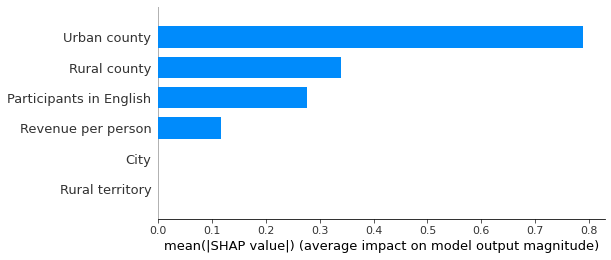

In [83]:
shap.summary_plot(shap_values, x, plot_type='bar', feature_names = pd.read_csv('data/combined/english.csv').columns[2:])

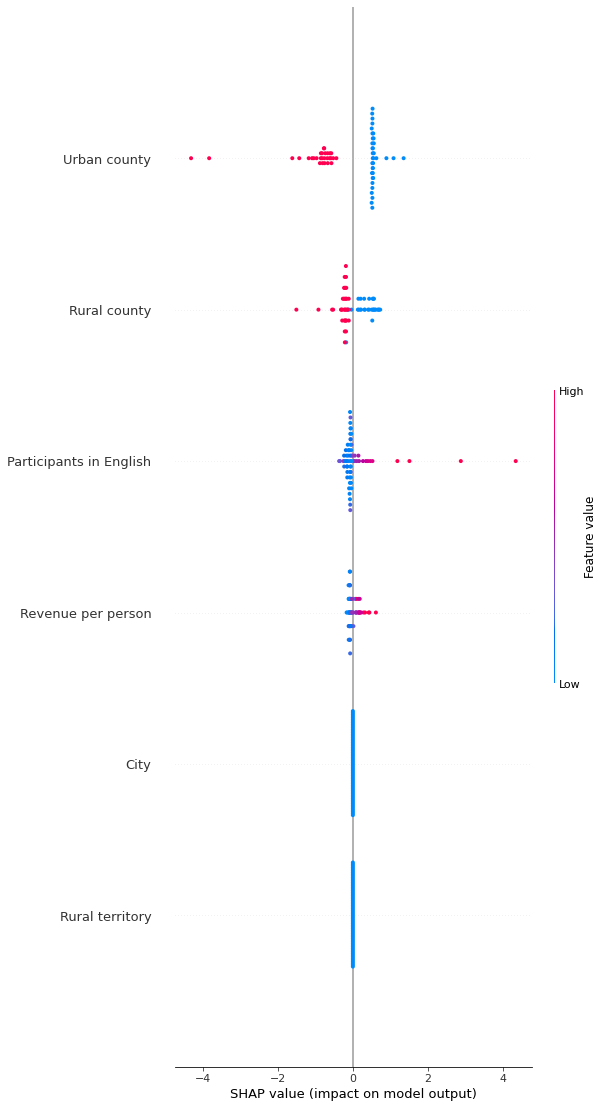

In [81]:
shap.summary_plot(shap_values, x, feature_names = pd.read_csv('data/combined/english.csv').columns[2:], plot_size=3)

In [64]:
model(dataset[0][0].unsqueeze(0))

tensor([[60.9037]], grad_fn=<ReluBackward0>)